In [263]:
import numpy as np
import gymnasium as gym

def harvest(pop, effort):
    q0 = 0.1
    q2 = 0.1 
    pop[0] = pop[0] * (1 - effort[0] * q0)
    pop[2] = pop[2] * (1 - effort[1] * q2)
    return pop

def utility(pop, effort):
    # benefit from harvesting X & Z, with fixed small fishing cost
    benefits = pop[0] * effort[0] + .01 * pop[2] * effort[1]
    costs = .01 * (effort[0] + effort[1])
    return benefits - costs

def observe(state): # perfectly observed case
    return state



In [264]:
class s3a2(gym.Env):
    """A 3-species ecosystem model with two control actions"""
    def __init__(self, config=None):
        config = config or {}
                                
        ## these parameters may be specified in config                                  
        self.Tmax = config.get("Tmax", 800)
        self.threshold = config.get("threshold", np.float32(1e-4))
        self.init_sigma = config.get("init_sigma", np.float32(1e-3))
        self.training = config.get("training", True)
        self.initial_pop = config.get("initial_pop", initial_pop)
        self.parameters = config.get("parameters", parameters)
        self.observe = config.get("observe", observe)
        self.harvest = config.get("harvest", harvest)
        self.utility = config.get("utility", utility)
        self.bound = 2 * self.parameters["K"]
        
        self.action_space = gym.spaces.Box(
            np.array([-1, -1], dtype=np.float32),
            np.array([1, 1], dtype=np.float32),
            dtype = np.float32
        )
        self.observation_space = gym.spaces.Box(
            np.array([-1, -1, -1], dtype=np.float32),
            np.array([1, 1, 1], dtype=np.float32),
            dtype=np.float32,
        )        
        self.reset(seed=config.get("seed", None))


    def reset(self, *, seed=None, options=None):
        self.timestep = 0
        self.state = self.state_units(self.initial_pop)
        self.state += np.float32(self.init_sigma * np.random.normal(size=3) )
        info = {}
        return self.observe(self.state), info

    def step(self, action):
        action = np.clip(action, self.action_space.low, self.action_space.high)
        pop = self.population_units(self.state) # current state in natural units
        effort = (action + 1.) / 2

        # harvest and recruitment
        reward = self.utility(pop, effort)
        nextpop = self.dynamics(pop, effort)
        
        self.timestep += 1
        terminated = bool(self.timestep > self.Tmax)
        
        # in training mode only: punish for population collapse
        if any(pop <= self.threshold) and self.training:
            terminated = True
            reward -= 50/self.timestep
        
        self.state = self.state_units(nextpop) # transform into [-1, 1] space
        observation = self.observe(self.state) # same as self.state
        return observation, reward, terminated, False, {}

      
    def dynamics(self, pop, effort):

        pop = self.harvest(pop, effort)        
        X, Y, Z = pop[0], pop[1], pop[2]
        p = self.parameters
        
        coupling = p["v0"]**2 #+ 0.02 * np.sin(2 * np.pi * self.timestep / 60)
        K = p["K"] #+ 0.1 * np.sin(2 * np.pi * self.timestep / 60)

        X += (p["r_x"] * X * (1 - (X + p["tau_xy"] * Y) / K)
              - p["beta"] * Z * (X**2) / (coupling + X**2)
              + p["sigma_x"] * X * np.random.normal()
             )
        
        Y += (p["r_y"] * Y * (1 - (Y + p["tau_yx"]* X ) / K )
              - p["D"] * p["beta"] * Z * (Y**2) / (coupling + Y**2)
              + p["sigma_y"] * Y * np.random.normal()
             )

        Z += p["f"] * p["beta"] * Z * (
             (X**2) / (coupling + X**2)
              + p["D"] * (Y**2) / (coupling + Y**2)
             ) + p["sigma_z"] * Z  * np.random.normal()
        
        # consider adding the handling-time component here too instead of these   
        #Z = Z + p["alpha"] * (Z * (p["f"] * (X + p["D"] * Y) - p["dH"]) 
        #                      + p["sigma_z"] * Z  * np.random.normal())
                              
        pop = np.array([X, Y, Z], dtype=np.float32)
        return(pop)

    
    # inverse of self.population()
    def state_units(self, pop):
        pop = np.clip(pop, 
                      np.repeat(0, pop.__len__()),
                      np.repeat(np.Inf, pop.__len__()))
    # enforce non-negative population first
        self.state = 2 * pop / self.bound - 1
        return np.float32(self.state)
    
    def population_units(self, state):
        pop = (state + 1) * self.bound /2
        return np.clip(pop, 
                       np.repeat(0, pop.__len__()),
                       np.repeat(np.Inf, pop.__len__()))
    
    
    


In [265]:

parameters = {
"r_x": np.float32(0.13),
"r_y": np.float32(0.2),
"K": np.float32(1),
"beta": np.float32(0.05),
"v0":  np.float32(0.1),
"D": np.float32(2.),
"tau_yx": np.float32(0),
"tau_xy": np.float32(0),
"f": np.float32(0.01), 
"dH": np.float32(0.06),
"alpha": np.float32(1),
"sigma_x": np.float32(0.05),
"sigma_y": np.float32(0.05),
"sigma_z": np.float32(0.05),
"cost": np.float32(0.01)
}


In [250]:

def utility(pop, effort):
    benefits = pop[1]
    costs = .01 * (effort[0] + effort[1])
    return benefits - costs

initial_pop = [0.5, 0.5, 0.2]

env = s3a2(config = {"utility": utility, 
                     "parameters": parameters, 
                     "initial_pop": initial_pop
                     })


array([0.49963498, 0.50126022, 0.2006228 ])

In [267]:

from stable_baselines3.common.env_checker import check_env
check_env(env)

action = np.array([-.9,-.999])

df = []
episode_reward = 0
observation, _ = env.reset()
for t in range(env.Tmax):
  obs = env.population_units(observation) # natural units
  df.append(np.append([t, episode_reward], obs))
  observation, reward, terminated, done, info = env.step(action)
  episode_reward += reward
#  if terminated or done:
#    break

episode_reward


9.146808809323023

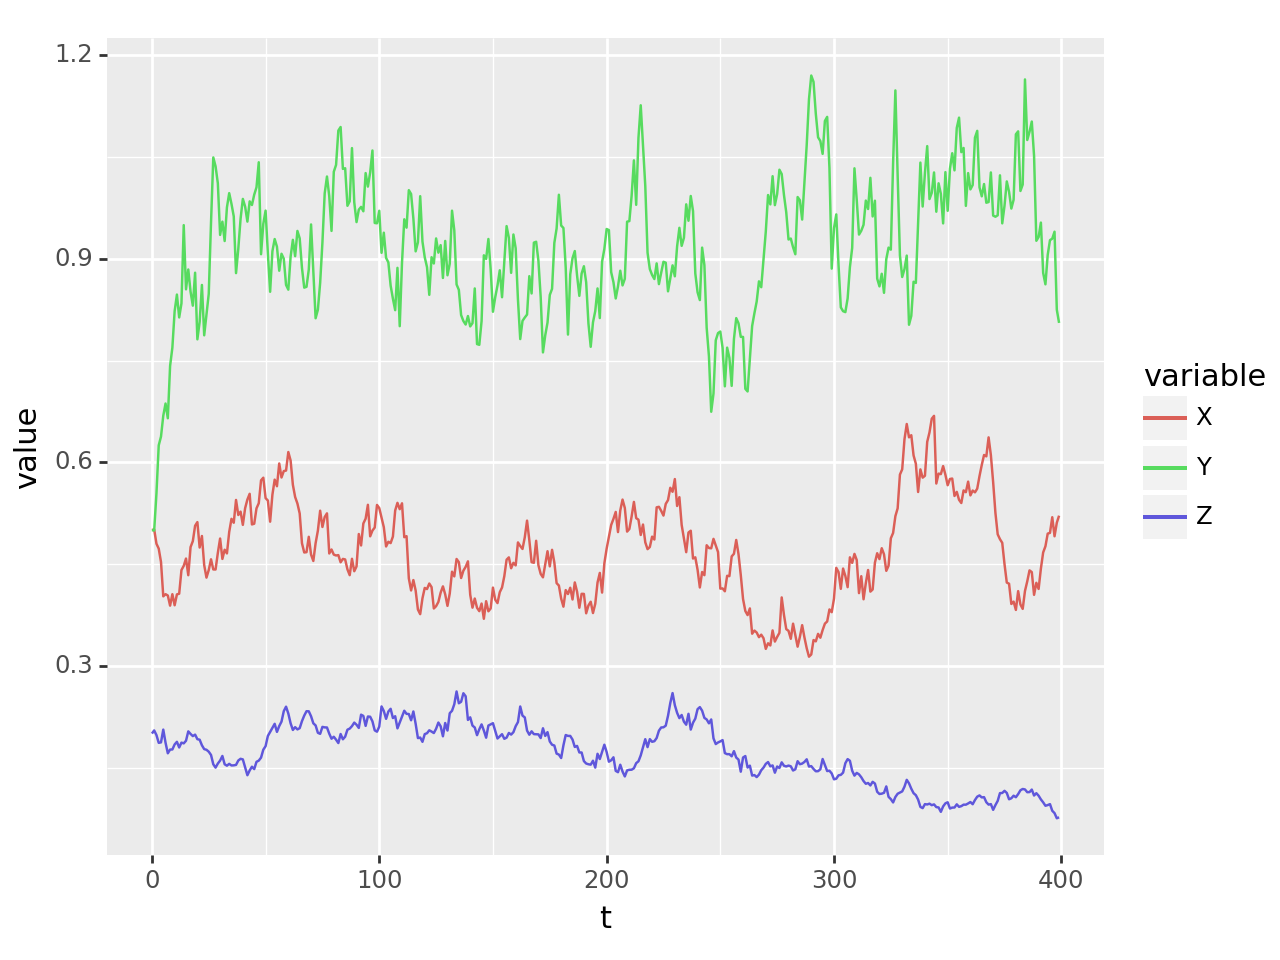

<Figure Size: (640 x 480)>

In [268]:

import polars as pl
from plotnine import ggplot, aes, geom_line
cols = ["t", "reward", "X", "Y", "Z"]

dfl = (pl.DataFrame(df, schema=cols).
        select(["t", "X", "Y", "Z"]).
        melt("t")
      )
ggplot(dfl, aes("t", "value", color="variable")) + geom_line()



In [ ]:
from sb3_contrib import TQC, ARS
from stable_baselines3 import PPO, A2C
#from stable_baselines3.common.env_util import make_vec_env

model = ARS("MlpPolicy", env, verbose=0, tensorboard_log="log")
model.learn(total_timesteps=600_000)
model.save("ars_fish")


In [274]:

model = PPO("MlpPolicy", env, verbose=0, tensorboard_log="log", use_sde=True)
model.learn(total_timesteps=500_000)
model.save("ppo_fish")

In [275]:
model = TQC("MlpPolicy", env, verbose=0, tensorboard_log="log", use_sde=True)
model.learn(total_timesteps=300_000)
model.save("tqc_fish")

KeyboardInterrupt: 